## 训练MLP，把2468从13类中分离出来

In [221]:
from torch.utils.data import DataLoader
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [222]:
from mlp import mlp
import torch
import pandas as pd
# precess training data
train_ft=torch.load('./features/features.pt')
url_ft=pd.read_csv('url_feature_train.csv')
url_ft=url_ft.iloc[:,:7].to_numpy()
train_ft=np.concatenate([train_ft.numpy(),url_ft],axis=-1)
train_label=pd.read_csv('./features/features_labels.csv')
train_label.value_counts()

label
2        2406
6        1099
4         886
10        786
11        424
8         291
9         180
3          52
1           7
7           6
5           2
12          1
dtype: int64

In [223]:
idx=(train_label['label']==2)|(train_label['label']==4)|(train_label['label']==6)|(train_label['label']==8)
train_label.loc[idx,'label']=2
train_label.value_counts()

label
2        4682
10        786
11        424
9         180
3          52
1           7
7           6
5           2
12          1
dtype: int64

In [224]:
def eval_on_test(net,features,labels):
    net.eval()
    global highest_record
    length=len(labels)
    labels=DataLoader(labels,batch_size=64)
    features=DataLoader(features,batch_size=64)
    sum=0
    for feature,label in zip(features,labels):
        output=net(feature)
        predict=torch.argmax(output,dim=-1)
        sum+=(predict==label).sum()
    if sum>highest_record:
        print(f'new record:{sum}')
        highest_record=sum
        torch.save(net.state_dict(),'./classifier_model/best_mlp.pkl')
    print(f"accuracy on test :{sum}/{length}={sum/length}")

In [225]:
def train(lr,batch_size,epoches,features_data,labels_data,test_features,test_labels,over_write=False):
    # load data
    labels=DataLoader(labels_data,batch_size=batch_size)
    features=DataLoader(features_data,batch_size=batch_size)
    # features_data=text_features
    print(features_data.shape)
    # !!!net and solver
    net=mlp(in_features=features_data.shape[-1])

    if os.path.exists('./classifier_model/mlp.pkl') and not over_write:
        state_dict=torch.load('./classifier_model/mlp.pkl')
        net.load_state_dict(state_dict=state_dict)
    criterion=torch.nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(net.parameters(),lr=lr)
    # train
    loss_list=[]
    for e in range(epoches):
        epoch_loss=[]
        for label,feature in zip(labels,features):
            net.train()
            output=net(feature)
            loss=criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        eval_on_test(net,features=test_features,labels=test_labels)
        mean_loss=np.array(epoch_loss).mean()
        loss_list.append(mean_loss)
        print(f'epoch {e+1} loss: {mean_loss}')
    loss_log=pd.DataFrame(loss_list,columns=['loss'])
    if os.path.exists('./log/loss.csv') and not over_write:
        f=pd.read_csv('./log/loss.csv')
        loss_log=pd.concat([f,loss_log],axis=0)
    loss_log.to_csv('./log/loss.csv',index=None)
    torch.save(net.state_dict(),'./classifier_model/mlp.pkl')


In [226]:
test_ft=torch.load('./features/features_test.pt')
test_url_ft=pd.read_csv('url_feature_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft],axis=-1)
test_label=pd.read_csv('./features/features_labels_test.csv')
test_label.value_counts()

label
2        594
6        274
4        234
10       193
11        97
8         73
9         54
3         10
12         3
1          2
7          2
dtype: int64

In [227]:
idx=(test_label['label']==2)|(test_label['label']==4)|(test_label['label']==6)|(test_label['label']==8)
test_label.loc[idx,'label']=2
print(len(test_label))
print(1175/1536)
test_label.value_counts()

1536
0.7649739583333334


label
2        1175
10        193
11         97
9          54
3          10
12          3
1           2
7           2
dtype: int64

In [217]:
highest_record

tensor(1277)

In [216]:
train(lr=1e-5,
      batch_size=32,
      epoches=10,
      features_data=torch.tensor(train_ft,dtype=torch.float32),
      labels_data=train_label['label'],
      test_features=torch.tensor(test_ft,dtype=torch.float32),
      test_labels=test_label['label'],
      over_write=False)

torch.Size([6140, 775])
accuracy on test :1272/1536=0.828125
epoch 1 loss: 0.2066579519159859
accuracy on test :1274/1536=0.8294270634651184
epoch 2 loss: 0.21087311134518436
accuracy on test :1276/1536=0.8307291865348816
epoch 3 loss: 0.21245287061901763
accuracy on test :1275/1536=0.830078125
epoch 4 loss: 0.2065952047899676
accuracy on test :1275/1536=0.830078125
epoch 5 loss: 0.20509792405452268
accuracy on test :1276/1536=0.8307291865348816
epoch 6 loss: 0.2042933967410742
accuracy on test :1276/1536=0.8307291865348816
epoch 7 loss: 0.20769229179131798
accuracy on test :1276/1536=0.8307291865348816
epoch 8 loss: 0.20397130278676437
accuracy on test :1277/1536=0.8313801884651184
epoch 9 loss: 0.20351721829501912
accuracy on test :1277/1536=0.8313801884651184
epoch 10 loss: 0.2062163016332003


### 训练LR，把2468分成24、68两组

In [228]:
from sklearn import metrics
import pickle
import joblib

In [229]:
#prepare data
train_ft=torch.load('./features/features.pt')
url_ft=pd.read_csv('url_feature_train.csv')
url_ft=url_ft.iloc[:,:7].to_numpy()
train_ft=np.concatenate([train_ft.numpy(),url_ft],axis=-1)
train_label=pd.read_csv('./features/features_labels.csv')
train_label.value_counts()
idx=(train_label['label']==2)|(train_label['label']==4)|(train_label['label']==6)|(train_label['label']==8)
train_label=train_label[idx]
train_label.value_counts()

label
2        2406
6        1099
4         886
8         291
dtype: int64

In [230]:
train_ft=train_ft[idx]
idx1=(train_label['label']==2)|(train_label['label']==6)
train_label[idx1]=2
idx2=(train_label['label']==4)|(train_label['label']==8)
train_label[idx2]=4
train_label.value_counts()

label
2        3505
4        1177
dtype: int64

In [231]:
test_ft=torch.load('./features/features_test.pt')
test_url_ft=pd.read_csv('url_feature_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft],axis=-1)
test_label=pd.read_csv('./features/features_labels_test.csv')
idx=(test_label['label']==2)|(test_label['label']==4)|(test_label['label']==6)|(test_label['label']==8)
test_ft=test_ft[idx]
test_label=test_label[idx]

In [232]:
idx1=(test_label['label']==2)|(test_label['label']==6)
idx2=(test_label['label']==4)|(test_label['label']==8)
test_label[idx1]=2
test_label[idx2]=4

In [241]:
LR24=LogisticRegression(max_iter=30000)
# LR24=SVC(max_iter=30000,kernel='rbf')
LR24.fit(train_ft,train_label)
LR24.score(test_ft,test_label)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9438297872340425

In [242]:
pred=LR24.predict(test_ft)
print(metrics.classification_report(test_label,pred))

              precision    recall  f1-score   support

           2       0.96      0.97      0.96       868
           4       0.90      0.88      0.89       307

    accuracy                           0.94      1175
   macro avg       0.93      0.92      0.93      1175
weighted avg       0.94      0.94      0.94      1175



In [243]:
#save model
joblib.dump(LR24,'./classifier_model/LR24.pkl')

['./classifier_model/LR24.pkl']

### 训练LR，把26分开

In [244]:
train_ft=torch.load('./features/features.pt')
url_ft=pd.read_csv('url_feature_train.csv')
url_ft=url_ft.iloc[:,:7].to_numpy()
train_ft=np.concatenate([train_ft.numpy(),url_ft],axis=-1)
train_label=pd.read_csv('./features/features_labels.csv')
idx=(train_label['label']==2)|(train_label['label']==6)
train_label=train_label[idx]
train_ft=train_ft[idx]
train_label.value_counts()

label
2        2406
6        1099
dtype: int64

In [245]:
test_ft=torch.load('./features/features_test.pt')
test_url_ft=pd.read_csv('url_feature_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft],axis=-1)
test_label=pd.read_csv('./features/features_labels_test.csv')
idx=(test_label['label']==2)|(test_label['label']==6)
test_ft=test_ft[idx]
test_label=test_label[idx]

In [254]:
LR26=SVC(max_iter=100000,kernel='rbf')
# LR26=LogisticRegression(max_iter=30000)
LR26.fit(train_ft,train_label)
LR26.score(test_ft,test_label)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8582949308755761

In [255]:
pred=LR26.predict(test_ft)
print(metrics.classification_report(test_label,pred))

              precision    recall  f1-score   support

           2       0.87      0.93      0.90       594
           6       0.82      0.70      0.76       274

    accuracy                           0.86       868
   macro avg       0.85      0.82      0.83       868
weighted avg       0.86      0.86      0.85       868



In [256]:
joblib.dump(LR26,'./classifier_model/LR26.pkl')

['./classifier_model/LR26.pkl']

### 训练LR，把48分开

In [257]:
train_ft=torch.load('./features/features.pt')
url_ft=pd.read_csv('url_feature_train.csv')
url_ft=url_ft.iloc[:,:7].to_numpy()
train_ft=np.concatenate([train_ft.numpy(),url_ft],axis=-1)
train_label=pd.read_csv('./features/features_labels.csv')
idx=(train_label['label']==4)|(train_label['label']==8)
train_label=train_label[idx]
train_ft=train_ft[idx]
train_label.value_counts()

label
4        886
8        291
dtype: int64

In [258]:
test_ft=torch.load('./features/features_test.pt')
test_url_ft=pd.read_csv('url_feature_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft],axis=-1)
test_label=pd.read_csv('./features/features_labels_test.csv')
idx=(test_label['label']==4)|(test_label['label']==8)
test_ft=test_ft[idx]
test_label=test_label[idx]

In [266]:
LR48=SVC(max_iter=100000,kernel='rbf')
# LR48=LogisticRegression(max_iter=30000)
LR48.fit(train_ft,train_label)
LR48.score(test_ft,test_label)

/Users/YZY/opt/anaconda3/envs/pytorch_cpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9055374592833876

In [267]:
pred=LR48.predict(test_ft)
print(metrics.classification_report(test_label,pred))

              precision    recall  f1-score   support

           4       0.91      0.97      0.94       234
           8       0.88      0.70      0.78        73

    accuracy                           0.91       307
   macro avg       0.90      0.83      0.86       307
weighted avg       0.90      0.91      0.90       307



In [268]:
joblib.dump(LR48,'./classifier_model/LR48.pkl')

['./classifier_model/LR48.pkl']

### 建立整体层次结构

In [272]:
class hierarchy_cls():
    def __init__(self) -> None:
        self.mlp=mlp(in_features=775)
        st=torch.load('./classifier_model/best_mlp.pkl')
        self.mlp.load_state_dict(st)
        self.LR24=joblib.load('./classifier_model/LR24.pkl')
        self.LR26=joblib.load('./classifier_model/LR26.pkl')
        self.LR48=joblib.load('./classifier_model/LR48.pkl')
    def predict(self,x):
        output=first_division=(torch.argmax(self.mlp(x),dim=-1)).numpy()
        idx_gp2=first_division==2
        # print(x.shape)
        features_2=x[idx_gp2]

        second_division=self.LR24.predict(features_2)
        # print(pd.DataFrame(second_division,columns=['0'])['0'].value_counts())
        idx_gp26=second_division==2
        idx_gp48=second_division==4
        ft_26=features_2[idx_gp26]
        ft_48=features_2[idx_gp48]

        pred_26=self.LR26.predict(ft_26)
        # print(pred_26)
        pred_48=self.LR48.predict(ft_48)
        # print(pd.DataFrame(output,columns=['0'])['0'].value_counts())
        gp2=output[idx_gp2]
        gp2[idx_gp48]=pred_48
        gp2[idx_gp26]=pred_26
        output[idx_gp2]=gp2
        # print(pd.DataFrame(output,columns=['0'])['0'].value_counts())
        return output


In [275]:
cls=hierarchy_cls()
test_ft=torch.load('./features/features_test.pt')
test_url_ft=pd.read_csv('url_feature_test.csv')
test_url_ft=test_url_ft.iloc[:,:7].to_numpy()
test_ft=np.concatenate([test_ft.numpy(),test_url_ft],axis=-1)
final_predict=cls.predict(torch.tensor(test_ft,dtype=torch.float32))

### 绘制混淆矩阵

In [276]:
import matplotlib.pyplot as plt
def draw_confusion_matrix(label,pred):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    c=confusion_matrix(label, pred)
    labels=list(set(label)|set(pred))
    print(labels)
    sns.heatmap(data=c,annot=True,fmt='g',xticklabels=labels,yticklabels=labels)
    plt.show()
    # plt.savefig('./confusion_matrix.png',dpi=720)

In [277]:
ana=pd.DataFrame(final_predict,columns=['label'])
ana['label'].value_counts()

2     594
4     277
6     254
10    199
11     95
8      64
9      44
3       5
1       2
7       2
Name: label, dtype: int64

1275/1536=0.830078125
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12]


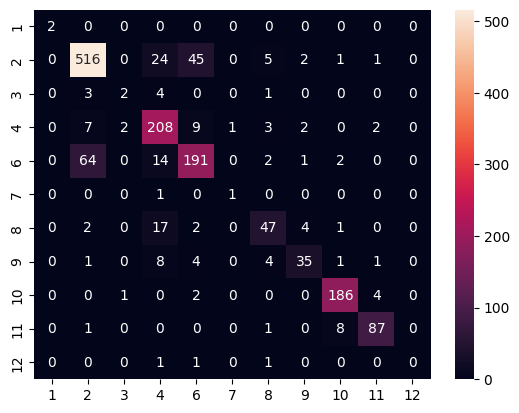

In [278]:
test_label=pd.read_csv('./features/features_labels_test.csv')
right=(test_label['label']==final_predict).sum()
length=len(final_predict)
print(f'{right}/{length}={right/length}')
draw_confusion_matrix(test_label['label'].to_numpy(),final_predict)